# Comparing LES

This notebook compares turbulent statistics simulated in the NCAR LES, a customized version of [PALM](https://palm.muk.uni-hannover.de/trac), and [Oceananigans](https://clima.github.io/OceananigansDocumentation/stable/).

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import string
sys.path.append('../lesview')
from lesview import *
from lesview.diags import get_bld_maxNN

In [2]:
# load data
ncarles_data_1d_pfl      = 'his.mp.vis.000001.036001.nc'
palm_data_1d_pfl         = 'DATA_1D_PR_NETCDF'
oceananigans_data_1d_pfl = 'averages.jld2'
casename = 'R7_BF05WD10WV00'
ncarles_dir = '../ncarles/LF17_Profile_data/{:s}_ST00_ens01'.format(casename)
palm_dir = '../palm/RUN_eoas_pgi_gpu_{:s}_256x256x256'.format(casename)
oceananigans_dir = '../oceananigans/advection_schemes/{:s}_WENO5'.format(casename)
ncarles_pfl      = NCARLESDataProfile(filepath=os.path.join(ncarles_dir, ncarles_data_1d_pfl))
palm_pfl         = PALMDataProfile(filepath=os.path.join(palm_dir, palm_data_1d_pfl))
oceananigans_pfl = OceananigansDataProfile(filepath=os.path.join(oceananigans_dir, oceananigans_data_1d_pfl))

Variable 't' has dimension 1. Skipping.


In [3]:
ustar = 0.012 # m/s
Q0 = 5/1000/4200
alpha = 2e-4
g = 9.81
B0 = Q0*g*alpha
Tstar = Q0/ustar
NNT0 = 0.01

In [4]:
# one inertial period (17 hours)
startdate = '2000-01-01T10:00:00'
enddate = '2000-01-02T03:00:00'
tslice = slice(startdate, enddate)

In [5]:
ncarles_var = {'T':       'txym',
               'u':       'uxym',
               'v':       'vxym',
               'w2':      'wps',
               'u2':      'ups',
               'v2':      'vps',
               'tke':     'englez',
               'uw':      'uwle',
               'vw':      'vwle',
               'wb':      'wtle',
               't2':      'tps',
               'w3':      'wcube'}
palm_var    = {'T':       'pt',
               'u':       'u',
               'v':       'v',
               'u2':      'u*2',
               'v2':      'v*2',
               'w2':      'w*2',
               'tke':     'e*', 
               'uw':      'w*u*',
               'vw':      'w*v*',
               'wb':      'w*pt*',
               't2':      'pt*2',
               'w3':      'w*3'}
oceananigans_var = {
               'T':       'T',
               'u':       'u',
               'v':       'v',
               'u2':      'uu',
               'v2':      'vv',
               'w2':      'ww',
               'tke':     'tke',
               'uw':      'wu',
               'vw':      'wv',
               'wb':      'wt',
               't2':      'tt',
               'w3':      'w3'}
models = ['NCAR LES', 'PALM', 'Oceananigans']
alpha = 2e-4
g = 9.81

In [6]:
def cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels,
            depth=-70, tslice=tslice, cmap='viridis'):
    
    ds0 = ncarles_pfl.dataset.data_vars[ncarles_var[var]].sel(time=tslice)
    ds1 = palm_pfl.dataset.data_vars[palm_var[var]].sel(time=tslice)
    if var == 'tke':
        # compute TKE
        uu = oceananigans_pfl.dataset.data_vars['uu'].sel(time=tslice)
        vv = oceananigans_pfl.dataset.data_vars['vv'].sel(time=tslice)
        ww = oceananigans_pfl.dataset.data_vars['ww'].sel(time=tslice)
        ds2 = 0.5*(uu+vv+ww.interp(zi=uu.z))
    else:
        ds2 = oceananigans_pfl.dataset.data_vars[oceananigans_var[var]].sel(time=tslice)
    if var == 'T':
        ds0 = ds0 - 273.15
        ds1 = ds1 - 273.15
    if var == 'wb':
        # convert temperature flux to buoyancy fluxe
        ds0 = ds0*g*alpha
        ds1 = ds1*g*alpha
        ds2 = ds2*g*alpha
    if var == 'u':
        if 'u_stk' in palm_pfl.dataset.data_vars:
            # convert Eulerian velocity to Lagrangian if Stokes drift exists in the data
            ds0 = ds0+ncarles_pfl.dataset.data_vars['stokes']
            ds1 = ds1+palm_pfl.dataset.data_vars['u_stk']
        
    fig1, axarr = plt.subplots(1, 3, sharey='row')
    fig1.set_size_inches([15, 3])
    ds0.plot(ax=axarr[0], levels=levels, add_colorbar=False, cmap=cmap)
    ds1.plot(ax=axarr[1], levels=levels, add_colorbar=False, cmap=cmap)
    im = ds2.plot(ax=axarr[2], levels=levels, add_colorbar=False, cmap=cmap)
    
    for j in np.arange(3):
        axarr[j].set_ylim([depth, 0])
        axarr[j].set_xlabel('')
        axarr[j].set_ylabel('')
        axarr[j].set_title(models[j])
    axarr[0].set_ylabel('depth (m)')

    plt.subplots_adjust(left=0.1, right=0.86, bottom=0.1, top=0.92, hspace=0.1)

    # colorbar
    cax = plt.axes([0.8, 0.1, 0.1, 0.8])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.formatter.set_powerlimits((-2, 3))
    cb.set_label(var+' ('+units+')')

    fig2 = plt.figure(figsize=[6,4])
    ds0.mean(dim='time').plot(y=ds0.dims[0], color='k', linestyle='-', label=models[0])
    ds1.mean(dim='time').plot(y=ds1.dims[0], color='k', linestyle='--', label=models[1])
    ds2.mean(dim='time').plot(y=ds2.dims[0], color='k', linestyle=':', label=models[2])
    vmin = np.min(levels)
    vmax = np.max(levels)
    plt.ylim([depth, 0])
    plt.xlim([vmin, vmax])
    plt.xlabel(var+' ('+units+')')
    plt.ylabel('Depth (m)')
    plt.title('Time averaged')
    plt.legend()

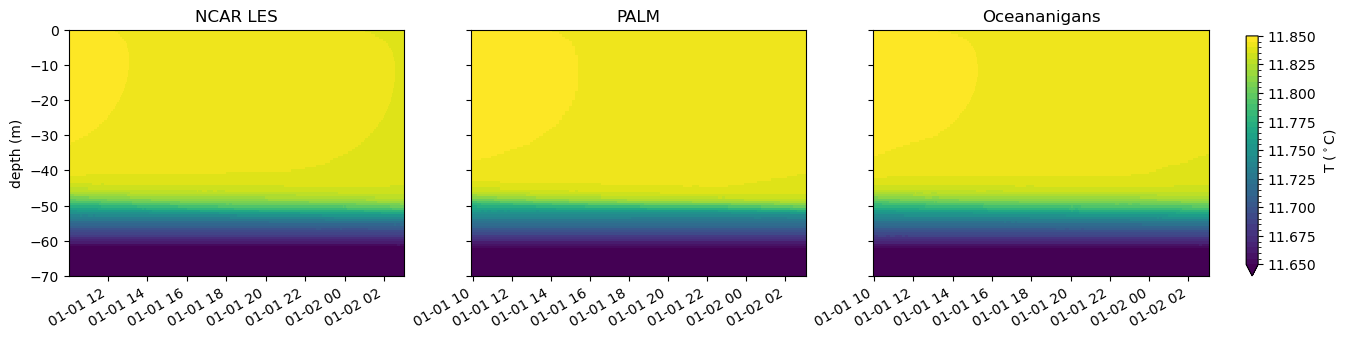

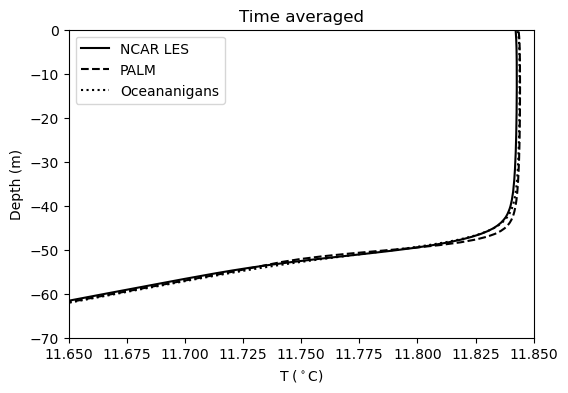

In [7]:
var = 'T'
units = '$^\circ$C'
levels = np.linspace(11.65, 11.85, 41)
# levels = None
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='viridis')

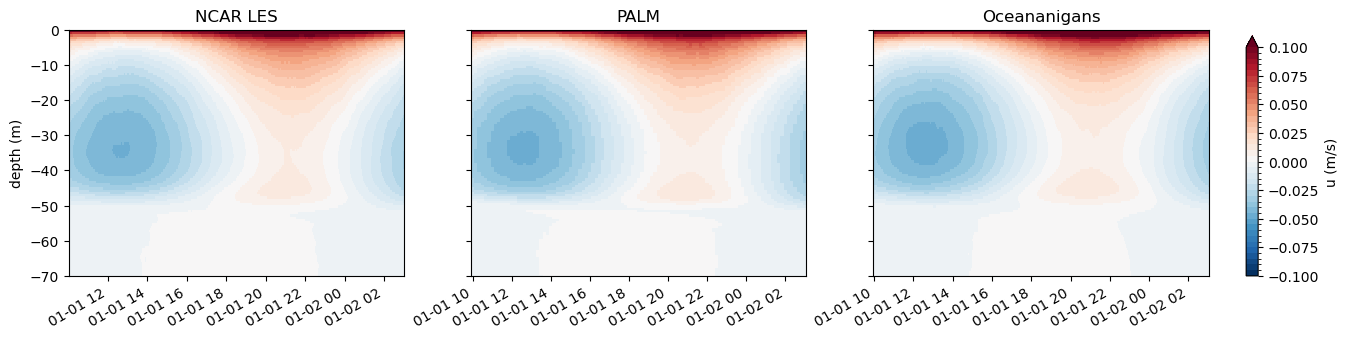

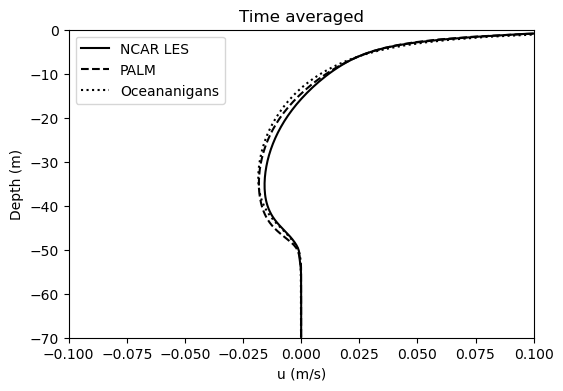

In [8]:
var = 'u'
units = 'm/s'
levels = np.linspace(-0.1, 0.1, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

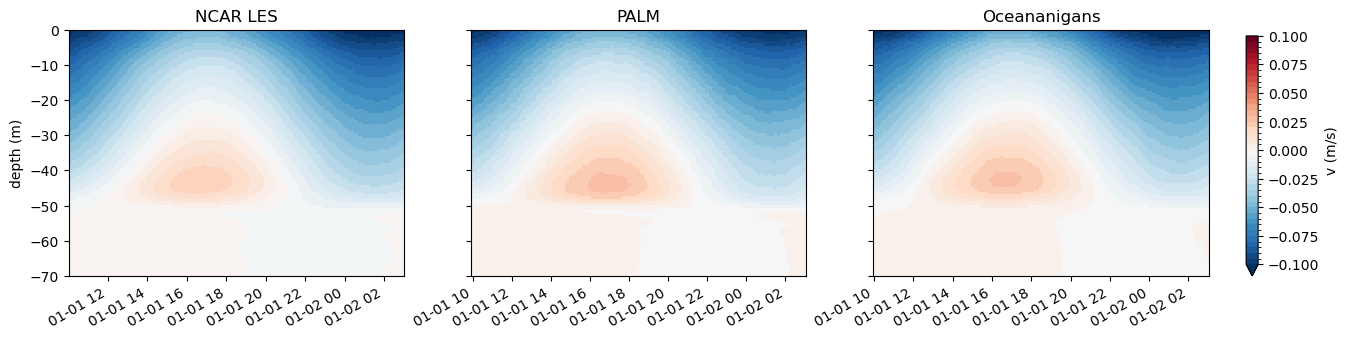

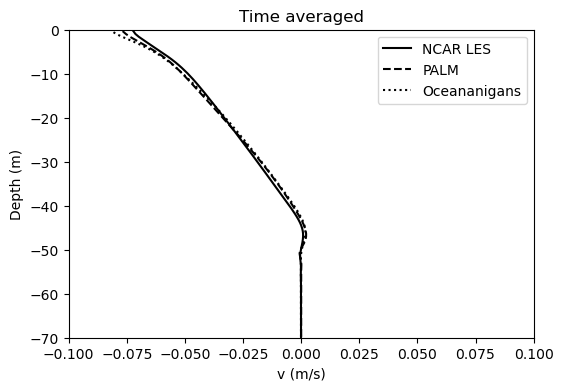

In [9]:
var = 'v'
units = 'm/s'
levels = np.linspace(-0.1, 0.1, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

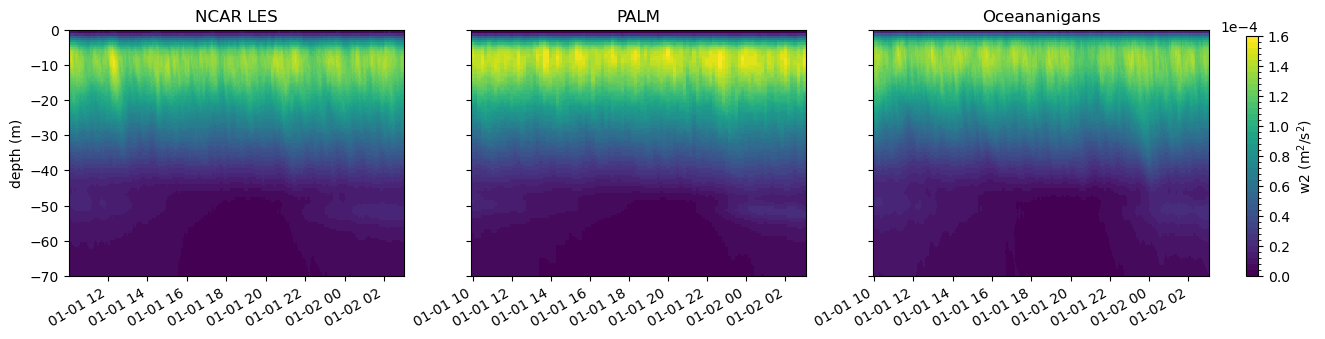

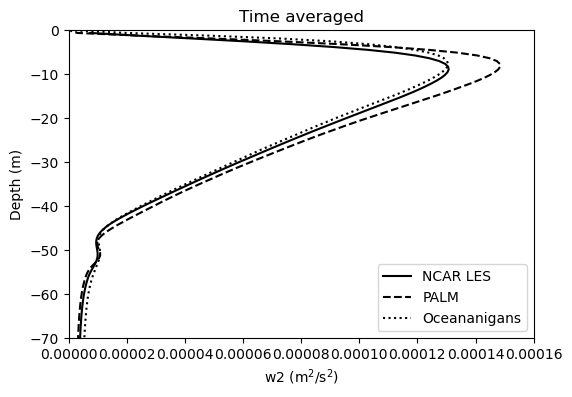

In [10]:
var = 'w2'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 1.6e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels)

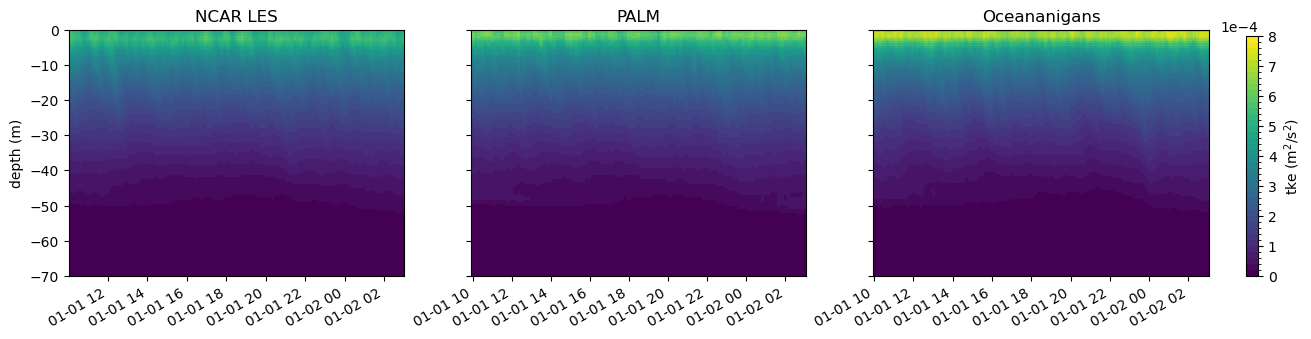

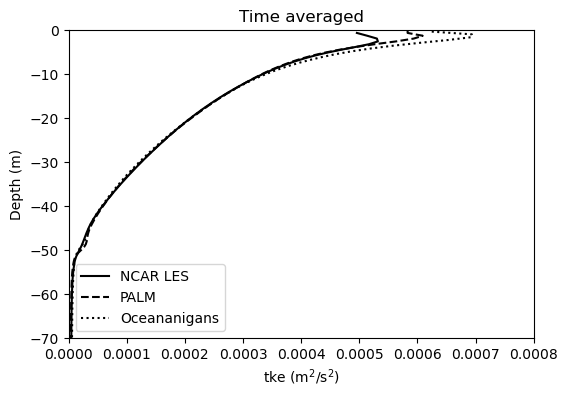

In [11]:
var = 'tke'
units = 'm$^2$/s$^2$'
levels = np.linspace(0, 8e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels)

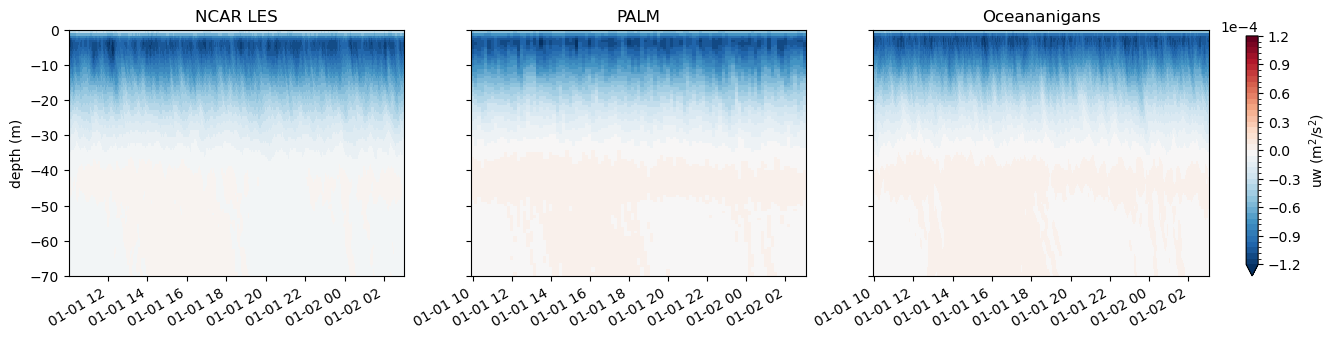

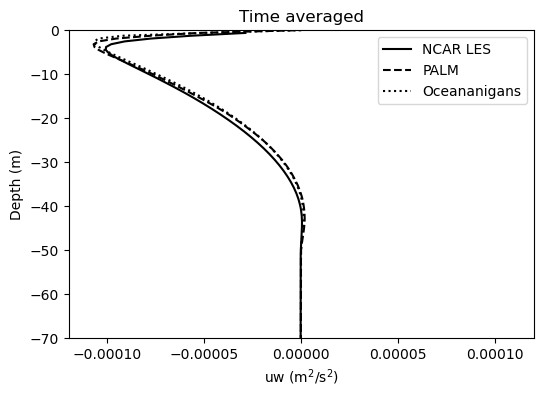

In [12]:
var = 'uw'
units = 'm$^2$/s$^2$'
levels = np.linspace(-1.2e-4, 1.2e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

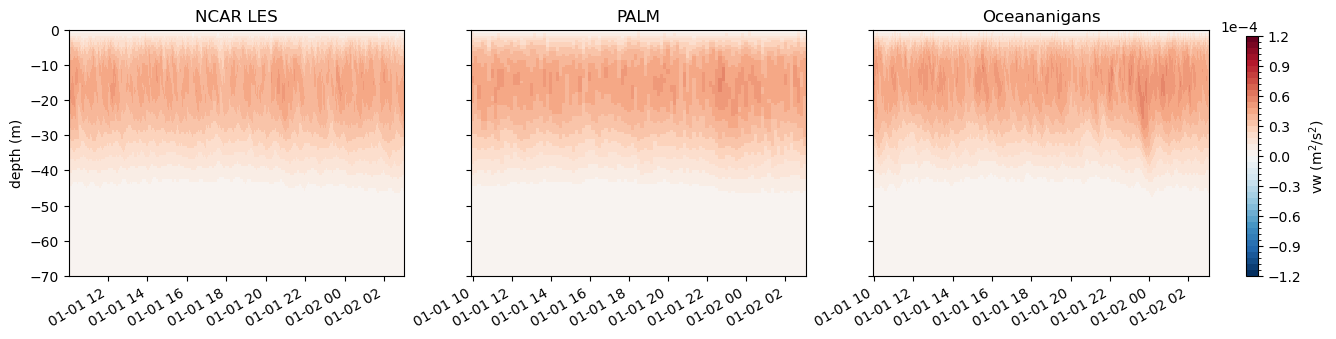

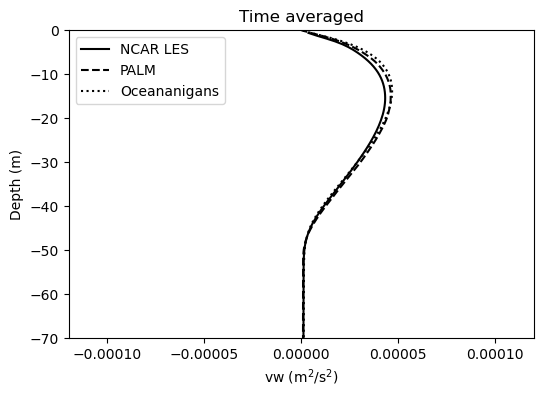

In [13]:
var = 'vw'
units = 'm$^2$/s$^2$'
levels = np.linspace(-1.2e-4, 1.2e-4, 41)
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

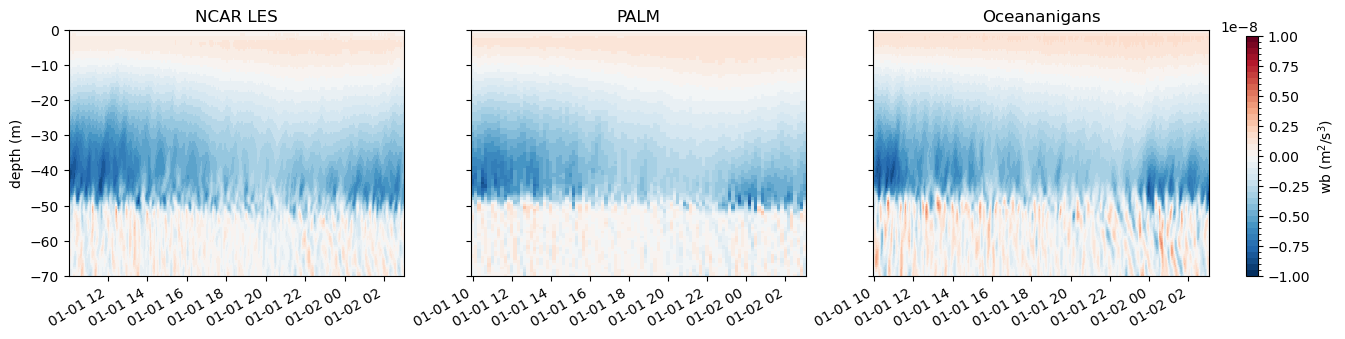

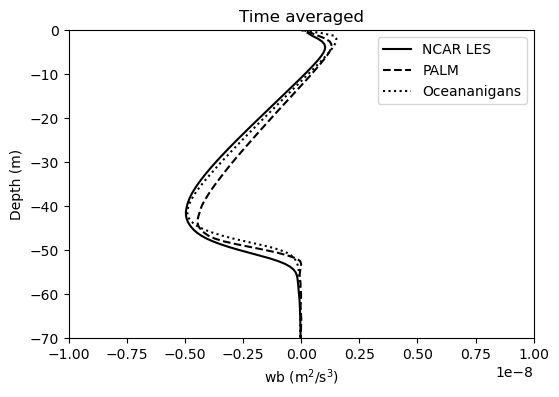

In [14]:
var = 'wb'
units = 'm$^{2}$/s$^{3}$'
levels = np.linspace(-1e-8, 1e-8, 41)
# levels = None
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

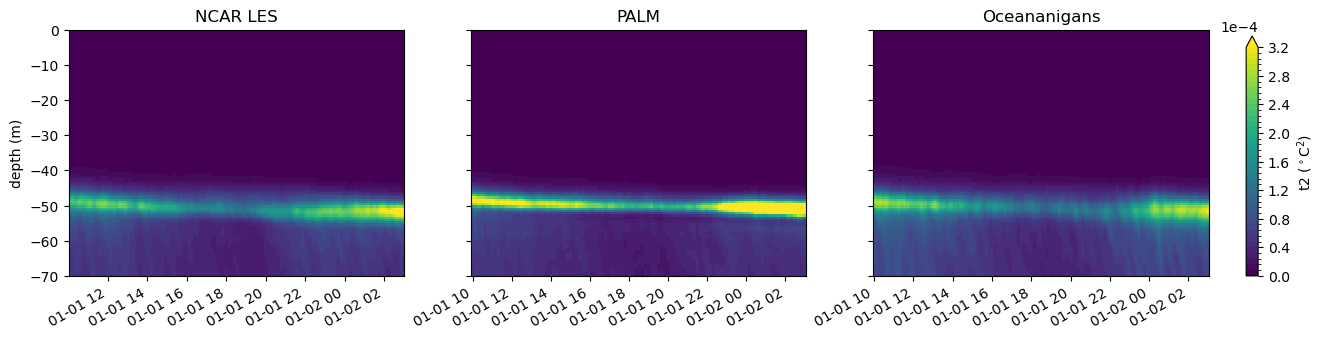

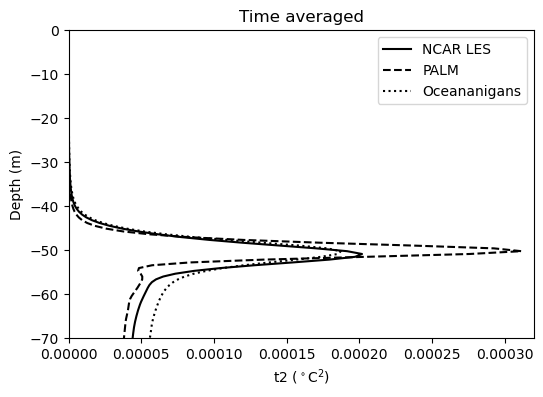

In [15]:
var = 't2'
units = '$^\circ$C$^2$'
levels = np.linspace(0, 3.2e-4, 41)
# levels = None
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels)

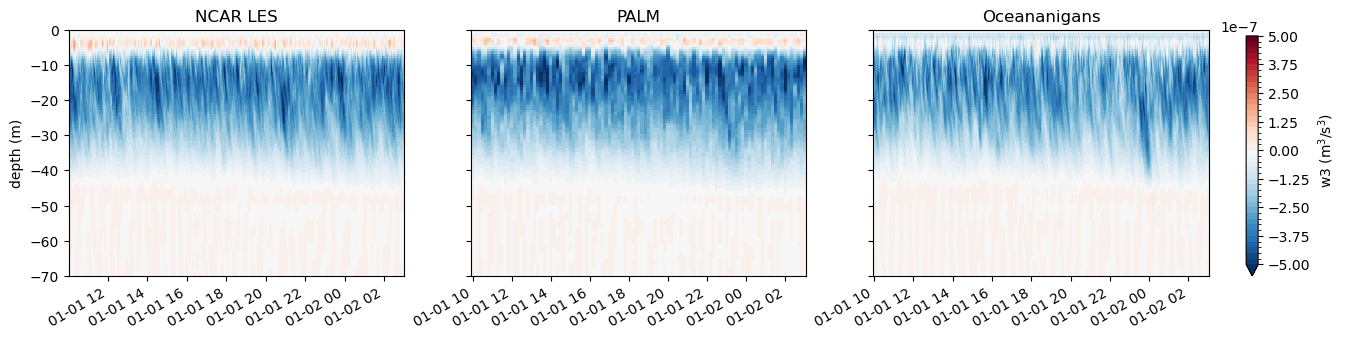

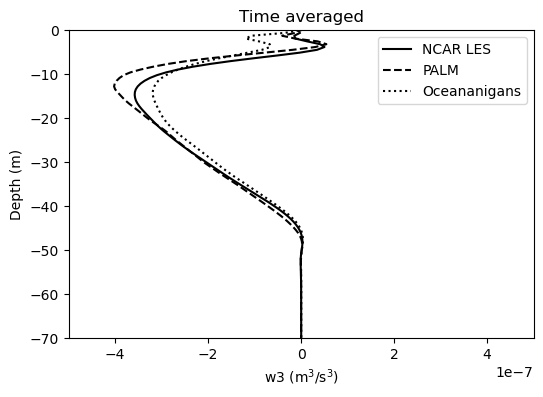

In [16]:
var = 'w3'
units = 'm$^3$/s$^3$'
levels = np.linspace(-5e-7, 5e-7, 41)
# levels = None
cmp_var(ncarles_pfl, palm_pfl, oceananigans_pfl, var, units, levels, cmap='RdBu_r')

In [17]:
ds0 = ncarles_pfl.dataset.sel(time=tslice).mean(dim='time')
ds1 = palm_pfl.dataset.sel(time=tslice).mean(dim='time')
ds2 = oceananigans_pfl.dataset.sel(time=tslice).mean(dim='time')

In [18]:
def plot_var(axis, ds0, ds1, ds2, var, color, vnorm=[1.]):
    if len(vnorm) == 1:
        vnorm0 = vnorm
        vnorm1 = vnorm
        vnorm2 = vnorm
    elif len(vnorm) == 3:
        vnorm0, vnorm1, vnorm2 = vnorm
    if var == 'skewness':
        da0 = ds0.data_vars[ncarles_var['w3']]/ds0.data_vars[ncarles_var['w2']]**1.5
        da1 = ds1.data_vars[palm_var['w3']]/ds1.data_vars[palm_var['w2']]**1.5
        da2 = ds2.data_vars[oceananigans_var['w3']]/ds2.data_vars[oceananigans_var['w2']]**1.5
    else:
        da0 = ds0.data_vars[ncarles_var[var]]/vnorm0
        da1 = ds1.data_vars[palm_var[var]]/vnorm1
        da2 = ds2.data_vars[oceananigans_var[var]]/vnorm2
    if var == 'T':
        da0 = da0 - 273.15
        da1 = da1 - 273.15
    if var == 'wb':
        # convert temperature flux to buoyancy fluxe
        da0 = da0*g*alpha
        da1 = da1*g*alpha
        da2 = da2*g*alpha
    da0.coords[da0.dims[0]] = da0.coords[da0.dims[0]]/mld0
    da1.coords[da1.dims[0]] = da1.coords[da1.dims[0]]/mld1
    da2.coords[da2.dims[0]] = da2.coords[da2.dims[0]]/mld2
    da0.plot(ax=axis, y=da0.dims[0], color=color, linestyle='-')
    da1.plot(ax=axis, y=da1.dims[0], color=color, linestyle='--')
    da2.plot(ax=axis, y=da2.dims[0], color=color, linestyle=':')

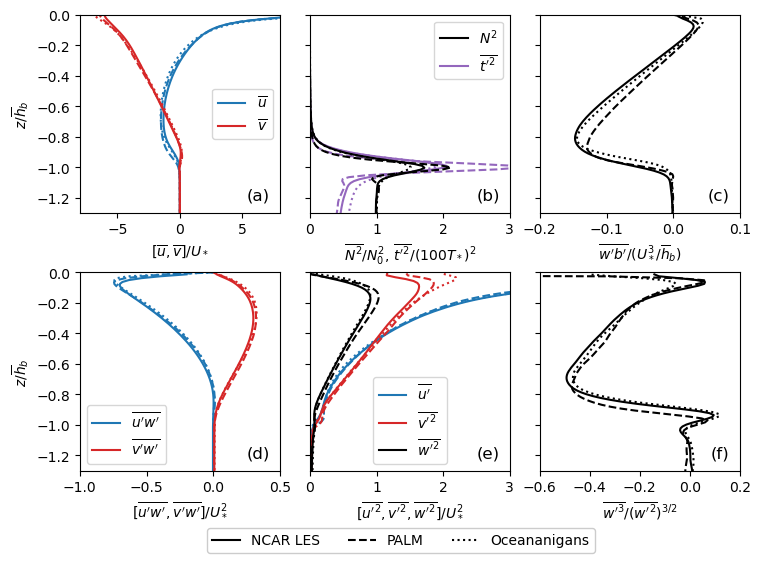

In [19]:
fig, axarr = plt.subplots(2, 3, sharey='row')
fig.set_size_inches([8, 6])

T0ts = ncarles_pfl.dataset.sel(time=tslice).data_vars[ncarles_var['T']]
T1ts = palm_pfl.dataset.sel(time=tslice).data_vars[palm_var['T']]
T2ts = oceananigans_pfl.dataset.sel(time=tslice).data_vars[oceananigans_var['T']]

NN0 = T0ts.differentiate(coord='z')
NN1 = T1ts.differentiate(coord='z')
NN2 = T2ts.differentiate(coord='z')

mld0 = get_bld_maxNN(NN0, zdim='z').mean(dim='time')
mld1 = get_bld_maxNN(NN1, zdim='z').mean(dim='time')
mld2 = get_bld_maxNN(NN2, zdim='z').mean(dim='time')


depth = -1.3
ylabel = '$z/\overline{h}_b$'

axis = axarr[0,0]
vnorm = [ustar]
vmin = -1.5
vmax = 1.5
plot_var(axis, ds0, ds1, ds2, 'u', 'tab:blue', vnorm=vnorm)
plot_var(axis, ds0, ds1, ds2, 'v', 'tab:red', vnorm=vnorm)
axis.set_ylim([depth, 0])
axis.set_xlim([-8, 8])
axis.set_xlabel('$[\overline{u},\overline{v}]/U_*$')
axis.set_ylabel(ylabel)
p1 = axis.plot(np.nan, np.nan, '-', color='tab:blue', label='$\overline{u}$')
p2 = axis.plot(np.nan, np.nan, '-', color='tab:red', label='$\overline{v}$')
axis.legend(loc = 'center right')

axis = axarr[0,1]
vnorm = [10000*Tstar**2]
plot_var(axis, ds0, ds1, ds2, 't2', 'tab:purple', vnorm=vnorm)
da0 = NN0.mean(dim='time')/NNT0
da1 = NN1.mean(dim='time')/NNT0
da2 = NN2.mean(dim='time')/NNT0
da0.coords[da0.dims[0]] = da0.coords[da0.dims[0]]/mld0
da1.coords[da1.dims[0]] = da1.coords[da1.dims[0]]/mld1
da2.coords[da2.dims[0]] = da2.coords[da2.dims[0]]/mld2
da0.plot(ax=axis, y='z', color='k', linestyle='-')
da1.plot(ax=axis, y='z', color='k', linestyle='--')
da2.plot(ax=axis, y='z', color='k', linestyle=':')
axis.set_ylim([depth, 0])
axis.set_xlim([0, 3])
axis.set_xlabel('$\overline{N^2}/N^2_0$, $\overline{{t\'}^2}/(100{T_*})^2$')
axis.set_ylabel('')
p1 = axis.plot(np.nan, np.nan, '-', color='k', label='$N^2$')
p2 = axis.plot(np.nan, np.nan, '-', color='tab:purple', label='$\overline{{t\'}^2}$')
axis.legend(loc = 'upper right')

axis = axarr[0,2]
vnorm = [ustar**3/mld0, ustar**3/mld1, ustar**3/mld2]
plot_var(axis, ds0, ds1, ds2, 'wb', 'k', vnorm=vnorm)
vmin = np.min(levels)
vmax = np.max(levels)
axis.set_ylim([depth, 0])
axis.set_xlim([-0.2, 0.1])
axis.set_xlabel('$\overline{w\'b\'}/(U_*^3/\overline{h}_b)$')
axis.set_ylabel('')


axis = axarr[1,0]
vnorm = [ustar**2]
plot_var(axis, ds0, ds1, ds2, 'uw', 'tab:blue', vnorm=vnorm)
plot_var(axis, ds0, ds1, ds2, 'vw', 'tab:red', vnorm=vnorm)
vmin = np.min(levels)
vmax = np.max(levels)
axis.set_ylim([depth, 0])
axis.set_xlim([-1, 0.5])
axis.set_xlabel('$[\overline{u\'w\'}, \overline{v\'w\'}]/U_*^2$')
axis.set_ylabel(ylabel)
p1 = axis.plot(np.nan, np.nan, '-', color='tab:blue', label='$\overline{u\'w\'}$')
p2 = axis.plot(np.nan, np.nan, '-', color='tab:red', label='$\overline{v\'w\'}$')
axis.legend()


axis = axarr[1,1]
vnorm = [ustar**2]
plot_var(axis, ds0, ds1, ds2, 'u2', 'tab:blue', vnorm=vnorm)
plot_var(axis, ds0, ds1, ds2, 'v2', 'tab:red', vnorm=vnorm)
plot_var(axis, ds0, ds1, ds2, 'w2', 'k', vnorm=vnorm)
vmin = np.min(levels)
vmax = np.max(levels)
axis.set_ylim([depth, 0])
axis.set_xlim([0, 3])
axis.set_xlabel('$[\overline{{u\'}^2}, \overline{{v\'}^2}, \overline{{w\'}^2}]/U_*^2$')
axis.set_ylabel('')
p1 = axis.plot(np.nan, np.nan, '-', color='tab:blue', label='$\overline{{u\'}}$')
p2 = axis.plot(np.nan, np.nan, '-', color='tab:red', label='$\overline{{v\'}^2}}$')
p3 = axis.plot(np.nan, np.nan, '-', color='k', label='$\overline{{w\'}^2}$')
axis.legend(loc = 'lower center')


axis = axarr[1,2]
vnorm = [ustar**3]
plot_var(axis, ds0, ds1, ds2, 'skewness', 'k', vnorm=vnorm)
vmin = np.min(levels)
vmax = np.max(levels)
axis.set_ylim([depth, 0])
axis.set_xlim([-0.6, 0.2])
axis.set_xlabel('$\overline{{w\'}^3}/(\overline{{w\'}^2})^{3/2}$')
axis.set_ylabel('')

axis.plot(np.nan, np.nan, color='k', linestyle='-', label=models[0])
axis.plot(np.nan, np.nan, color='k', linestyle='--', label=models[1])
axis.plot(np.nan, np.nan, color='k', linestyle=':', label=models[2])
axis.legend(loc='lower left', ncol=3, bbox_to_anchor=(-1.7, -0.45), framealpha=1)

for i in np.arange(2):
    for j in np.arange(3):
        k = i*3+j
        ax = axarr[i,j]
        ax.text(0.95, 0.05, '('+string.ascii_lowercase[k]+')',
                    transform=ax.transAxes, fontsize=12, va='bottom', ha='right')

plt.subplots_adjust(top=0.93, bottom=0.17, right=0.95, hspace=0.3, wspace=0.15)
figname = 'compare_les_{}.png'.format(casename)
fig.savefig(figname, dpi=300, facecolor='w')